## Chapter 8: Multivariate Linear Regression

The core of many machine learning algorithms is optimization. Optimization algorithms are used by machine learning algorithms to find a good set of model parameters given a training dataset. The most common optimization algorithm used in machine learning is stochastic gradient descent. In this tutorial, you will discover how to implement stochastic gradient descent to optimize a linear regression algorithm from scratch with Perl. After completing this tutorial, you will know:

- How to estimate linear regression coefficients using stochastic gradient descent.  
- How to make predictions for multivariate linear regression.  
- How to implement linear regression with stochastic gradient descent to make predictions on new data. Let's get started.

### 8.1 Description

In this section, we will describe linear regression, the stochastic gradient descent technique and the Wine Quality dataset used in this tutorial.

#### 8.1.1 Multivariate Linear Regression

Linear regression is a technique for predicting a real value. Confusingly, these problems where a real value is to be predicted are called regression problems. Linear regression is a technique where a straight line is used to model the relationship between input and output values. In more than two dimensions, this straight line may be thought of as a plane or hyperplane. Predictions are made as a combination of the input values to predict the output value. Each input attribute (x) is weighted using a coefficient (b), and the goal of the learning algorithm is to discover a set of coefficients that results in good predictions (y).


Coefficients can be found using stochastic gradient descent.

#### 8.1.2 Stochastic Gradient Descent

Gradient Descent is the process of minimizing a function following the slope or gradient of that function. In machine learning, we can use a technique that evaluates and updates the coefficients every iteration called stochastic gradient descent to minimize the error of a model on our training data. The way this optimization algorithm works is that each training instance is shown to the model one at a time. The model makes a prediction for a training instance, the error is calculated and the model is updated in order to reduce the error for the next prediction. This process is repeated for a fixed number of iterations. This procedure can be used to find the set of coefficients in a model that result in the smallest error for the model on the training data. Each iteration, the coefficients (b) in machine learning language are updated using the equation:


Where **b** is the coefficient or weight being optimized, **learning rate** is a learning rate that you must configure (e.g. 0.01), **error** is the prediction error for the model on the training data attributed to the weight, and **x** is the input value.

### 8.1.3 Wine Quality Dataset

In this tutorial we will use the Wine Quality Dataset. This dataset involves the prediction of white Wine Quality. The baseline RMSE on the problem is approximately 0.148 quality points. You can learn more about it in Appendix A, Section A.3. Download the dataset and save it into your current working directory with the filename `winequality-white.csv`. You must remove the header information from the file and convert the semicolon character (;) separator to the comma character (,) to meet CSV format.

## 8.2 Tutorial

This tutorial is broken down into 3 parts:

1. Making Predictions.  
2. Estimating Coefficients.  
3. Wine Quality Case Study. This will provide the foundation you need to implement and apply linear regression with stochastic gradient descent on your own predictive modeling problems.

### 8.2.1 Making Predictions

The first step is to develop a function that can make predictions. This will be needed both in the evaluation of candidate coefficient values in stochastic gradient descent and after the model is finalized and we wish to start making predictions on test data or new data. Below is a function named `predict()` that predicts an output value for a row given a set of coefficients.

The first coefficient in is always the intercept, also called the bias or b0 as it is standalone and not responsible for a specific input value.


In [1]:
import mxnet as mx
from sml import SML
import matplotlib.pyplot as plt

sml = SML()

In [2]:
def predict(row, coef):

    yhat = coef[0] + mx.nd.dot(row, coef[1:row.shape[0]+1])
    return yhat

sml.add_to_class(sml, 'predict', predict)

In [3]:
dataset_nd = mx.nd.array([
    [1, 1],
    [2, 3],
    [4, 3],
    [3, 2],
    [5, 5]
], dtype="float32")

X_nd = dataset_nd[:, 0]
Y_nd = dataset_nd[:, 1]

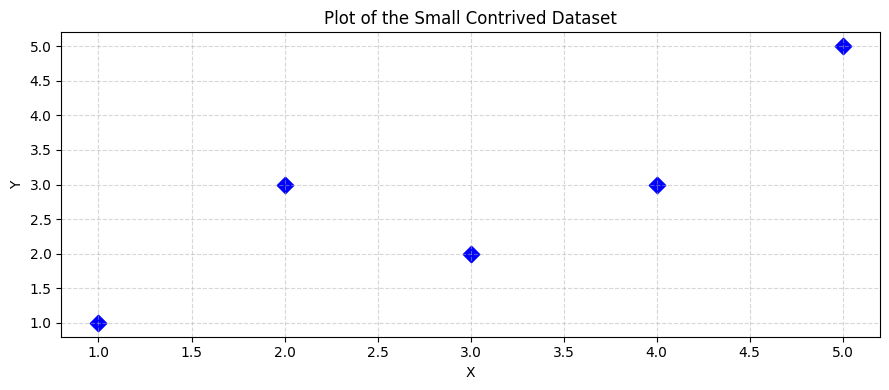

In [4]:
X = X_nd.asnumpy()
Y = Y_nd.asnumpy()

plt.figure(figsize=(9, 4))          # ancho 9 in, alto 4 in ≈ 900×400 px
plt.scatter(X, Y, marker='D', s=70, color='blue')   # 'D' = diamond
plt.title("Plot of the Small Contrived Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

We can also use previously prepared coefficients to make predictions for this dataset. Putting this all together we can test our `predict()` function below.

There is a single input value (x) and two coefficient values (b0 and b1). The prediction equation we have modeled for this problem is:

<p align="center"><i>y = b0 + b1 × x</i> (8.3)</p>

Or, with the specific coefficient values we chose by hand as:

<p align="center"><i>y = 0.4 + 0.8 × x</i> (8.4)</p>

Running this function we get predictions that are reasonably close to the expected output (y) values.

In [5]:
coef_nd = mx.nd.array([0.4, 0.8])

for row_nd in dataset_nd:
    x_nd  = row_nd[0:1]                  # NDArray escalar
    y_exp = row_nd[1].asscalar()       # expected (float)
    
    # SML.predict espera lista o NDArray solo con características (sin y)
    y_hat = sml.predict(x_nd, coef_nd).asscalar()
    
    print(f"Expected={y_exp:.3f}, Predicted={y_hat:.3f}")

Expected=1.000, Predicted=1.200
Expected=3.000, Predicted=2.000
Expected=3.000, Predicted=3.600
Expected=2.000, Predicted=2.800
Expected=5.000, Predicted=4.400


### 8.2.2 Estimating Coefficients

We can estimate the coefficient values for our training data using stochastic gradient descent. Stochastic gradient descent requires two parameters:

- **Learning Rate**: Used to limit the amount that each coefficient is corrected each time it is updated.  
- **Epochs**: The number of times to run through the training data while updating the coefficients. These, along with the training data will be the arguments to the function. There are 3 loops we need to perform in the function:

    1. Loop over each epoch.  
    2. Loop over each row in the training data for an epoch.  
    3. Loop over each coefficient and update it for a row in an epoch.

As you can see, we update each coefficient for each row in the training data, each epoch. Coefficients are updated based on the error the model made. The error is calculated as the difference between the prediction made with the candidate coefficients and the expected output value.

$$
\text{error} = \text{prediction} - \text{expected} \tag{8.5}
$$

There is one coefficient to weight each input attribute, and these are updated in a consistent way, for example:

$$
b1(t + 1) = b1(t) - \text{learning\_rate} \times \text{error}(t) \times x1(t) \tag{8.6}
$$

The special coefficient at the beginning of the list, also called the intercept or the bias, is updated in a similar way, except without an input as it is not associated with a specific input value:

$$
b0(t + 1) = b0(t) - \text{learning\_rate} \times \text{error}(t) \tag{8.7}
$$

Now we can put all of this together. Below is a function named `coefficients_sgd_linear()` that calculates coefficient values for a training dataset using stochastic gradient descent.

In [6]:
def coefficients_sgd_linear(train, l_rate, n_epoch, test=None, metric=None):
    if test is not None:
        test = test.astype("float32")

    num_features = train.shape[1] - 1
    coef = mx.nd.zeros(num_features + 1, dtype="float32")  # [b0, b1, …]

    train_loss, test_loss = [], []

    for epoch in range(int(n_epoch)):
        sum_error = 0.0

        for row in train:                     # SGD: instancia por instancia
            yhat = coef[0] + mx.nd.dot(row[:num_features], coef[1:])
            error = yhat - row[num_features]
            sum_error += float((error ** 2).asscalar())

            # Actualizar bias
            coef[0] -= l_rate * error
            # Actualizar pesos
            coef[1:] -= l_rate * error * row[:num_features]

        train_loss.append(sum_error)

        # ---- cálculo de pérdida en test (opcional) ----
        if test is not None:
            sum_err_test = 0.0
            for row in test:
                yhat = coef[0] + mx.nd.dot(row[:num_features], coef[1:])
                error = yhat - row[num_features]
                sum_err_test += float((error ** 2).asscalar())
            test_loss.append(sum_err_test)

        # Log cada 10 épocas
        if epoch % 10 == 0:
            print(f"epoch={epoch}, lrate={l_rate:.5f}, error={sum_error:.2f}")

    return (coef, train_loss, test_loss) if test is not None else (coef, train_loss)

sml.add_to_class(sml, 'coefficients_sgd_linear', coefficients_sgd_linear)

You can see that, in addition, we keep track of the sum of the squared error (a positive value) each epoch so that we can print out a nice message in the outer loop.  
We can test this function on the same small contrived dataset from above.

We use a small learning rate of **0.001** and train the model for **50 epochs**, or 50 exposures of the coefficients to the entire training dataset.  
Running the example prints a message each epoch with the sum-squared error for that epoch and the final set of coefficients.

In [7]:
l_rate  = 0.001
n_epoch = 50

# Entrenar y obtener coeficientes y pérdida por época
coef_nd, train_loss = sml.coefficients_sgd_linear(dataset_nd, l_rate, n_epoch)

print("Final coefficients (b0, b1):", coef_nd.asnumpy())

epoch=0, lrate=0.00100, error=46.24
epoch=10, lrate=0.00100, error=15.71
epoch=20, lrate=0.00100, error=6.46
epoch=30, lrate=0.00100, error=3.66
epoch=40, lrate=0.00100, error=2.81
Final coefficients (b0, b1): [0.22998218 0.8017221 ]


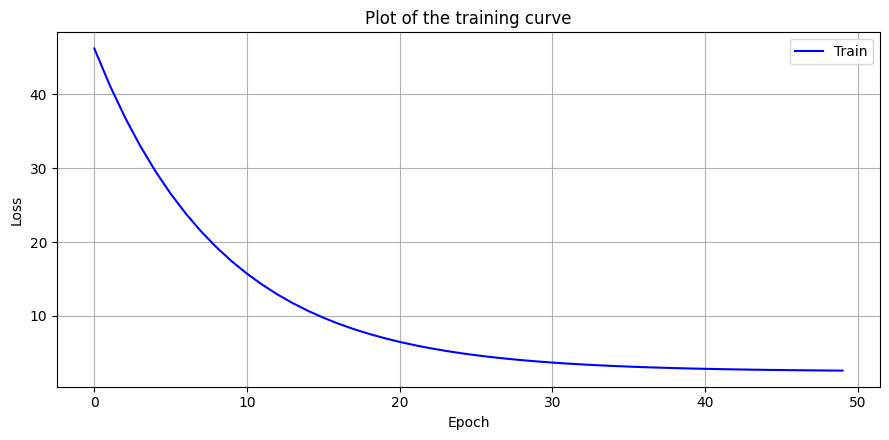

In [8]:
epochs = list(range(len(train_loss)))

plt.figure(figsize=(9, 4.5))  # 900x450 px aproximadamente
plt.plot(epochs, train_loss, label='Train', color='blue')
plt.title('Plot of the training curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

You can see how error continues to drop even in the final epoch. We could probably train for a lot longer (more epochs) or increase the amount we update the coefficients each epoch (higher learning rate). Experiment and see what you come up with. Now, let's apply this algorithm on a real dataset.

### 8.2.3 Wine Quality Case Study

In this section, we will train a linear regression model using stochastic gradient descent on the Wine Quality dataset. The example assumes that a CSV copy of the dataset is in the current working directory with the filename `winequality-white.csv`. The dataset is first loaded, the string values converted to numeric and each column is normalized to values in the range of 0 to 1. This is achieved with helper functions `load_csv()` and `str_column_to_float()` to load and prepare the dataset and `dataset_minmax()` and `normalize_dataset()` to normalize it. We will use k-fold cross-validation to estimate the performance of the learned model on unseen data. This means that we will construct and evaluate **k** models and estimate the performance as the mean model error. **Root mean squared error** will be used to evaluate each model. These behaviors are provided in the `cross_validation_split()`, `rmse_metric()` and `evaluate_algorithm()` helper functions.

We will use the `predict()`, `coefficients_sgd_linear()` and `linear_regression_sgd()` functions created above to train the model. Below is the complete example.

In [20]:
def linear_regression_sgd(train, test, *, l_rate, n_epoch, metric=None):
    coef, train_loss, test_loss = sml.coefficients_sgd_linear(
        train,
        l_rate,
        n_epoch,
        test=test,
        metric=metric
    )

    # 2. Generar predicciones para cada fila de test
    predictions = []
    num_features = test.shape[1] - 1  # descarta la y al final

    for row in test:
        yhat = coef[0] + mx.nd.dot(row[:num_features], coef[1:])
        predictions.append(yhat.asscalar())

    predictions_nd = mx.nd.array(predictions, dtype='float32')
    return predictions_nd, train_loss, test_loss


# (Opcional) inyectar en SML
sml.add_to_class(SML, 'linear_regression_sgd', staticmethod(linear_regression_sgd))

In [16]:
mx.random.seed(1)

filename = "./data/winequality-white.csv"
data_list, header = sml.load_csv(filename)

dataset_nd = mx.nd.array(data_list, dtype="float32")

minmax = sml.dataset_minmax(dataset_nd)          # matriz 2×n con min y max
print("Min/Max por columna:\n", minmax.asnumpy())

Min/Max por columna:
 [[3.80000e+00 1.42000e+01]
 [8.00000e-02 1.10000e+00]
 [0.00000e+00 1.66000e+00]
 [6.00000e-01 6.58000e+01]
 [9.00000e-03 3.46000e-01]
 [2.00000e+00 2.89000e+02]
 [9.00000e+00 4.40000e+02]
 [9.87110e-01 1.03898e+00]
 [2.72000e+00 3.82000e+00]
 [2.20000e-01 1.08000e+00]
 [8.00000e+00 1.42000e+01]
 [3.00000e+00 9.00000e+00]]


In [17]:
sml.normalize_dataset(dataset_nd, minmax)
print("Primeras 2 filas normalizadas:\n", dataset_nd[:2].asnumpy())

Primeras 2 filas normalizadas:
 [[0.30769232 0.18627453 0.21686748 0.3082822  0.10682493 0.14982578
  0.37354988 0.26778546 0.25454545 0.26744184 0.1290323  0.5       ]
 [0.24038465 0.21568629 0.20481928 0.01533742 0.11869437 0.04181185
  0.28538284 0.1328321  0.5272727  0.3139535  0.24193549 0.5       ]]


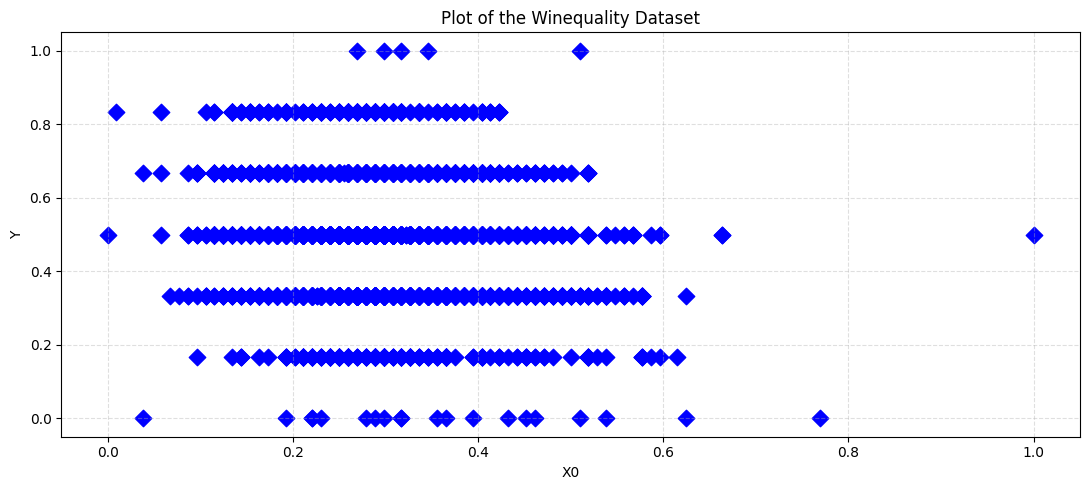

In [18]:
transp_dataset = dataset_nd.T

X = transp_dataset[0].asnumpy()
Y = transp_dataset[-1].asnumpy()

plt.figure(figsize=(11, 5))
plt.scatter(X, Y, marker='D', color='blue', s=70)
plt.title('Plot of the Winequality Dataset')
plt.xlabel('X0')
plt.ylabel('Y')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [21]:
mx.random.seed(1)

n_folds  = 5
l_rate   = 0.00001
n_epoch  = 50

scores, train_losses, test_losses, _, _ = SML.evaluate_algorithm_cross_validation_split(
    dataset_nd,
    lambda tr, te: sml.linear_regression_sgd(
        tr, te, l_rate=l_rate, n_epoch=n_epoch
    ),
    n_folds=n_folds,
    metric="rmse",
    return_all=True
)

epoch=0, lrate=0.00001, error=925.50
epoch=10, lrate=0.00001, error=292.96
epoch=20, lrate=0.00001, error=132.96
epoch=30, lrate=0.00001, error=92.29
epoch=40, lrate=0.00001, error=81.77
epoch=0, lrate=0.00001, error=929.50
epoch=10, lrate=0.00001, error=294.66
epoch=20, lrate=0.00001, error=134.10
epoch=30, lrate=0.00001, error=93.29
epoch=40, lrate=0.00001, error=82.73
epoch=0, lrate=0.00001, error=928.26
epoch=10, lrate=0.00001, error=293.58
epoch=20, lrate=0.00001, error=133.06
epoch=30, lrate=0.00001, error=92.29
epoch=40, lrate=0.00001, error=81.75
epoch=0, lrate=0.00001, error=921.61
epoch=10, lrate=0.00001, error=292.48
epoch=20, lrate=0.00001, error=133.10
epoch=30, lrate=0.00001, error=92.54
epoch=40, lrate=0.00001, error=82.05
epoch=0, lrate=0.00001, error=927.78
epoch=10, lrate=0.00001, error=293.84
epoch=20, lrate=0.00001, error=133.12
epoch=30, lrate=0.00001, error=92.18
epoch=40, lrate=0.00001, error=81.58


A k value of 5 folds was used for cross-validation, giving each fold 4,898 / 5 = 979.6 or just under 1000 records to be evaluated upon each iteration.  
A learning rate of 0.00001 and 50 training epochs were chosen with a little experimentation.  
You can try your own configurations and see if you can beat my score.  

Running this example prints the scores for each of the 5 cross-validation folds then prints the mean RMSE.  
We can see that the RMSE (on the normalized dataset) is **0.128**, lower than the baseline value of **0.140**.

In [26]:
def mean(values):
    if isinstance(values, mx.nd.NDArray):
        return mx.nd.mean(values).asscalar()

    # Caso 2 - lista vacía
    if len(values) == 0:
        raise ValueError("mean() recibió una lista vacía")

    first = values[0]

    # Caso 3 - lista de NDArray (0-D o mismos dims)
    if isinstance(first, mx.nd.NDArray):
        stacked = mx.np.stack([v.as_np_ndarray() for v in values])
        return mx.np.mean(stacked).item()    # .item() → float

    # Caso 4 - lista de escalares
    return sum(values) / len(values)
    
sml.add_to_class(SML, 'mean', mean)

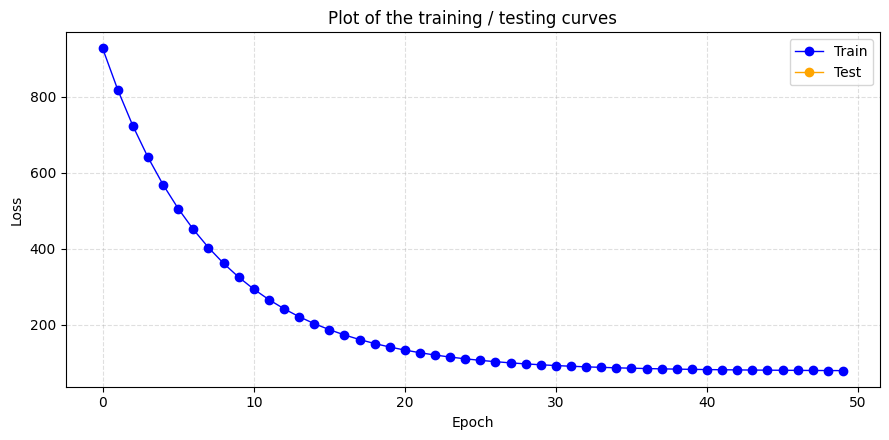

Scores: [0.143, 0.139, 0.143, 0.143, 0.143]
Mean RMSE: 0.142


In [30]:
def mean(values):
    if isinstance(values[0], mx.nd.NDArray):
        stacked = mx.nd.stack(*values)
        return mx.nd.mean(stacked).asscalar()
    else:
        return float(sum(values)) / len(values)

mx.npx.set_np()

train_loss_mean = list(map(mean, zip(*train_losses)))
test_loss_mean  = list(map(mean, zip(*test_losses)))

# Crear eje X con los índices de época
epochs = list(range(len(train_loss_mean)))

# Crear la gráfica
plt.figure(figsize=(9, 4.5))  # Aproximadamente 900x450 píxeles

plt.plot(epochs, train_loss_mean,
         label='Train', color='blue', linestyle='-', marker='o', linewidth=1)

plt.plot(epochs, test_loss_mean,
         label='Test', color='orange', linestyle='-', marker='o', linewidth=1)

plt.title('Plot of the training / testing curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar los RMSE de cada fold y el promedio
scores_float = list(map(float, scores))
print("Scores:", scores_float)
print(f"Mean RMSE: {mx.np.mean(mx.np.array(scores_float)):.3f}")

# 8.3 Learning rate differences in scalar and vectorized approaches

Let’s compare how the learning rate (`l_rate`) affects model training in both the vectorized and devectorized (scalar) versions of `coefficients_sgd_linear`.

## 8.3.1 Core Similarity

In both approaches, the learning rate:

- Scales the gradient (how far off the prediction is from the target).
- Controls the step size used to update model parameters (coefficients).

Both versions follow the same logic:

```
coef = coef - l_rate * gradient
```

## 8.3.2 Scalar Approach

```perl
coef->[0] -= l_rate * error;
coef->[i+1] -= l_rate * error * x;
```

**Characteristics:**

- **Stochastic (SGD):** Updates weights one training example at a time.
- Learning rate is applied per sample, so it's directly proportional to the size of the error from one example.
- More volatile, especially with noisy data.

**Learning Rate Implication:**

- You need a **smaller learning rate** (e.g., `0.00001`, `0.001`) to avoid unstable updates.
- Can adapt faster to changes in data but also risks overshooting or oscillation.

## 8.3.3 Vectorized Approach

```perl
gradient = mx->nd->dot(X_bias->T, error) / X->len;

coef = coef - l_rate * gradient;
```

# 8.4 Extensions

This section lists a number of extensions to this tutorial that you may wish to consider exploring.

- **Tune The Example:** Tune the learning rate, number of epochs and even the data.
- **Batch Stochastic Gradient Descent:** Change the stochastic gradient descent algorithm to accumulate updates across each epoch and only update the coefficients in a batch at the end of the epoch.
- **Additional Regression Problems:** Apply the technique to other regression problems on the UCI machine learning repository.

**Characteristics:**

- **Batch-based updates:** Computes the gradient for all training examples in one go.
- Learning rate is divided over the number of samples (due to averaging):  
  ```
  gradient = total_gradient / N
  ```

This makes the effective learning rate smaller and more stable, which helps when training with large batches.

- Efficient and consistent, especially when training with GPUs or large datasets.

**Learning Rate Implication:**

- You can use a **larger learning rate** (e.g., `0.01`, `0.1`) because the averaging smooths the updates.
- Less sensitive to noise from individual data points.


## Comparison Table

| Feature                  | Scalar Approach            | Vectorized Approach        |
|--------------------------|----------------------------|-----------------------------|
| Update granularity       | Per sample                 | Batch                       |
| Gradient smoothing       | No (raw per sample)        | Yes (averaged)              |
| Recommended learning rate| Lower (`0.00001`, `0.001`) | Higher (`0.01`, `0.1`)      |
| Stability                | More volatile              | More stable                 |
| Training speed (runtime) | Slower                     | Faster (especially on GPU)  |
| Reactivity to noise      | More                       | Less                        |


# 8.5 Review

In this tutorial, you discovered how to implement linear regression using stochastic gradient descent from scratch with Python. Specifically, you learned:

- How to make predictions for a multivariate linear regression problem.
- How to optimize a set of coefficients using stochastic gradient descent.
- How to apply the technique to a real regression predictive modeling problem.